In [2]:
from sklearn.model_selection import train_test_split
from src.baseline_experiments import *
from src.TopoExplanation import *
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
import gudhi as gd

## Import Diabetes dataset

In [3]:
df = pd.read_csv("../dataset/diabetes.csv")
df.drop(columns=["p_id"], inplace=True)

In [4]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

## Train a neural network model with two hidden layers

In [5]:
batch_size = 16
num_epochs = 100
learning_rate = 4e-3
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train_tens = torch.tensor(X_train.to_numpy()).float()
X_test_tens = torch.tensor(X_test.to_numpy()).float()

In [7]:
unique, counts = np.unique(y_train, return_counts=True)
    
averaging = 'binary'
y_train_tens = torch.tensor(y_train.to_numpy()).view(-1, 1).float()
output_dim = 1

In [8]:
device = torch.device("cpu")

dataset_tens = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
train_iter = torch.utils.data.DataLoader(dataset_tens, batch_size, shuffle=False)

print("Try to load the model..")
model = nn_model.get_model(device, train_iter, X_train.shape[1], output_dim, averaging, learning_rate, num_epochs)

Try to load the model..
Train model
Epoch 020: | Loss: 0.31375 | Acc: 86.731 | F1: 79.33569
Epoch 040: | Loss: 0.27204 | Acc: 88.577 | F1: 82.85091
Epoch 060: | Loss: 0.21117 | Acc: 92.769 | F1: 89.20712
Epoch 080: | Loss: 0.19074 | Acc: 93.577 | F1: 90.00909
Epoch 100: | Loss: 0.13092 | Acc: 95.769 | F1: 93.27354
Set to eval


In [9]:
X_test_tens = torch.tensor(X_test.to_numpy()).float()
X_test_c, Y_test_c = get_correct_predictions(model,X_test.reset_index(drop=True),X_test_tens,y_test.reset_index(drop=True),averaging)
X_test_c_tens = torch.from_numpy(X_test_c.to_numpy(dtype=np.float32))

X_test of correct predictions shape: (152, 8)
Y_test of correct predictions shape: (152,)
Label in Y_test of correct predictions ratio: 
 [[  0 108]
 [  1  44]]


## Use the sigmoid function as the prediction probability function for Mapper

[<matplotlib.lines.Line2D at 0x7fbac0397690>]

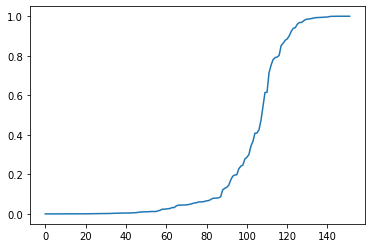

In [10]:
predictions = torch.sigmoid(model(X_test_c_tens)).detach().numpy()
plt.plot(np.sort(predictions.flatten()))

## Compute the Explanations of (IntGrad, SHAP, DeepLIFT) $\times$ (Zero, Max Distances, Uniform, Gaussian, Train)-Baselines (15 explanation outputs in total)


In [11]:
np.random.seed(rs)
torch.manual_seed(rs)

print("Loading all baselines..")
bun = BaselineUtilTensor()
black_baseline = bun.create_black_baseline(X)
uniform_baseline = bun.create_uniform_baseline(X)
gaussian_baseline = bun.create_gaussian_baseline(X, 0.5)
train_baseline = bun.create_train_baseline(X)

Loading all baselines..


In [239]:
explanations = {}
methods = ['IG','DeepSHAP','DeepLIFT']
target = None
for method in methods:
    bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr = get_attr_scores(method, X_test_c_tens, None, black_baseline,uniform_baseline,gaussian_baseline, train_baseline, model,X.min(), X.max(), X.columns)
    explanations[method] = [bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr]
    for exp in explanations[method]:
        exp[exp>5]=5
        exp[exp<-5]=-5

Start integrated gradients for correct predictions with black_baseline
--- '0.14' seconds computation time ---
Start integrated gradients for correct predictions with max_dist_baseline
--- '0.71' seconds computation time ---
Start integrated gradients for correct predictions with uniform_baseline
--- '1.34' seconds computation time ---
Start integrated gradients for correct predictions with gaussian_baseline
--- '1.39' seconds computation time ---
Start integrated gradients for correct predictions with train_baseline
--- '1.33' seconds computation time ---
Start DeepSHAP for correct predictions with black_baseline
--- '0.23' seconds computation time ---
Start DeepSHAP for correct predictions with max_dist_baseline
--- '0.32' seconds computation time ---
Start DeepSHAP for correct predictions with uniform_baseline
--- '2.20' seconds computation time ---
Start DeepSHAP for correct predictions with gaussian_baseline
--- '2.13' seconds computation time ---
Start DeepSHAP for correct predic

## Parameter Tuning for Mapper

### Step 1: Compute the Mapper outputs for different resolutions and gains

In [218]:
resolutions=[5,10,15,20,25]
gains=[0.1,0.2,0.3,0.4,0.5]
all_bootstrap_dist = []
function = predictions.reshape(-1,1)
for method in methods:
    for exp in explanations[method]:
        bootstrap_dist = []
        for r in reversed(resolutions):
            b = []
            for g in gains:
                params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
                  "resolutions": np.array([r]), "gains": np.array([g]), "inp": "point cloud", 
                  "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=3)}
                b.append(bootstrap_mapper(exp,params))
            bootstrap_dist.append(b) 
        all_bootstrap_dist.append(bootstrap_dist)

### Step 2: Visualize the 95% CI bootstrap distances and identify the minima
#### Note: Red rectangles are the parameter combination that we choose when we run the notebook. This can be changed when the outputs from the explanations are different due to randomness.

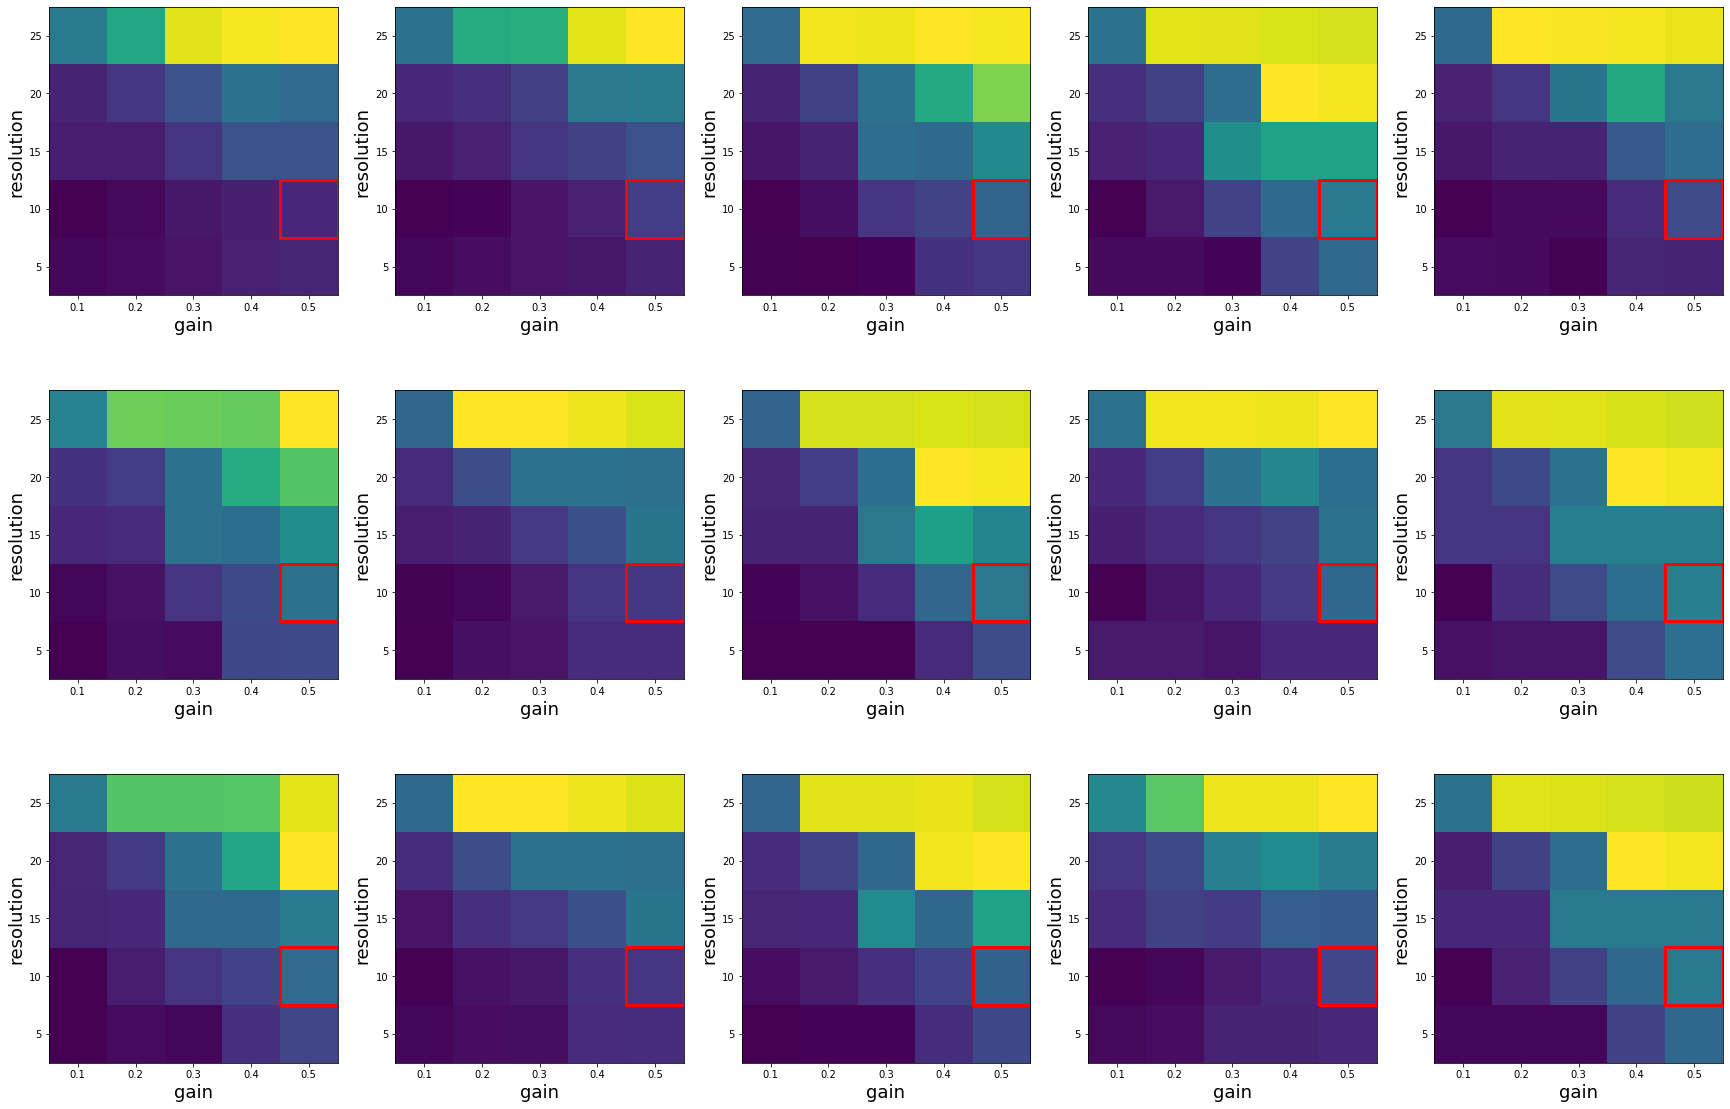

In [222]:
axes = plt.subplots(3, 5, figsize=(30,20))[1].reshape(-1)
vmin = np.min(all_bootstrap_dist)
vmax = np.max(all_bootstrap_dist)
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

for b,ax in zip(all_bootstrap_dist,axes):
    ax.imshow(b)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(gains)
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(resolutions)
    ax.set_ylim(-.5,4.5)
    ax.set_xlabel('gain', fontsize=18)
    ax.set_ylabel('resolution', fontsize=18)
    highlight_cell(4,1, ax=ax,color="red", linewidth=3)

## Generate the resulted Mapper Graphs

In [242]:
resolution = 10
gain = 0.5
all_mappers = []
function = predictions
params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
          "resolutions": np.array([resolution]), "gains": np.array([gain]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=10)}
for method in methods:
    i = 0
    for exp in explanations[method]:
        M = MapperComplex(**params).fit(exp)
        all_mappers.append(M)

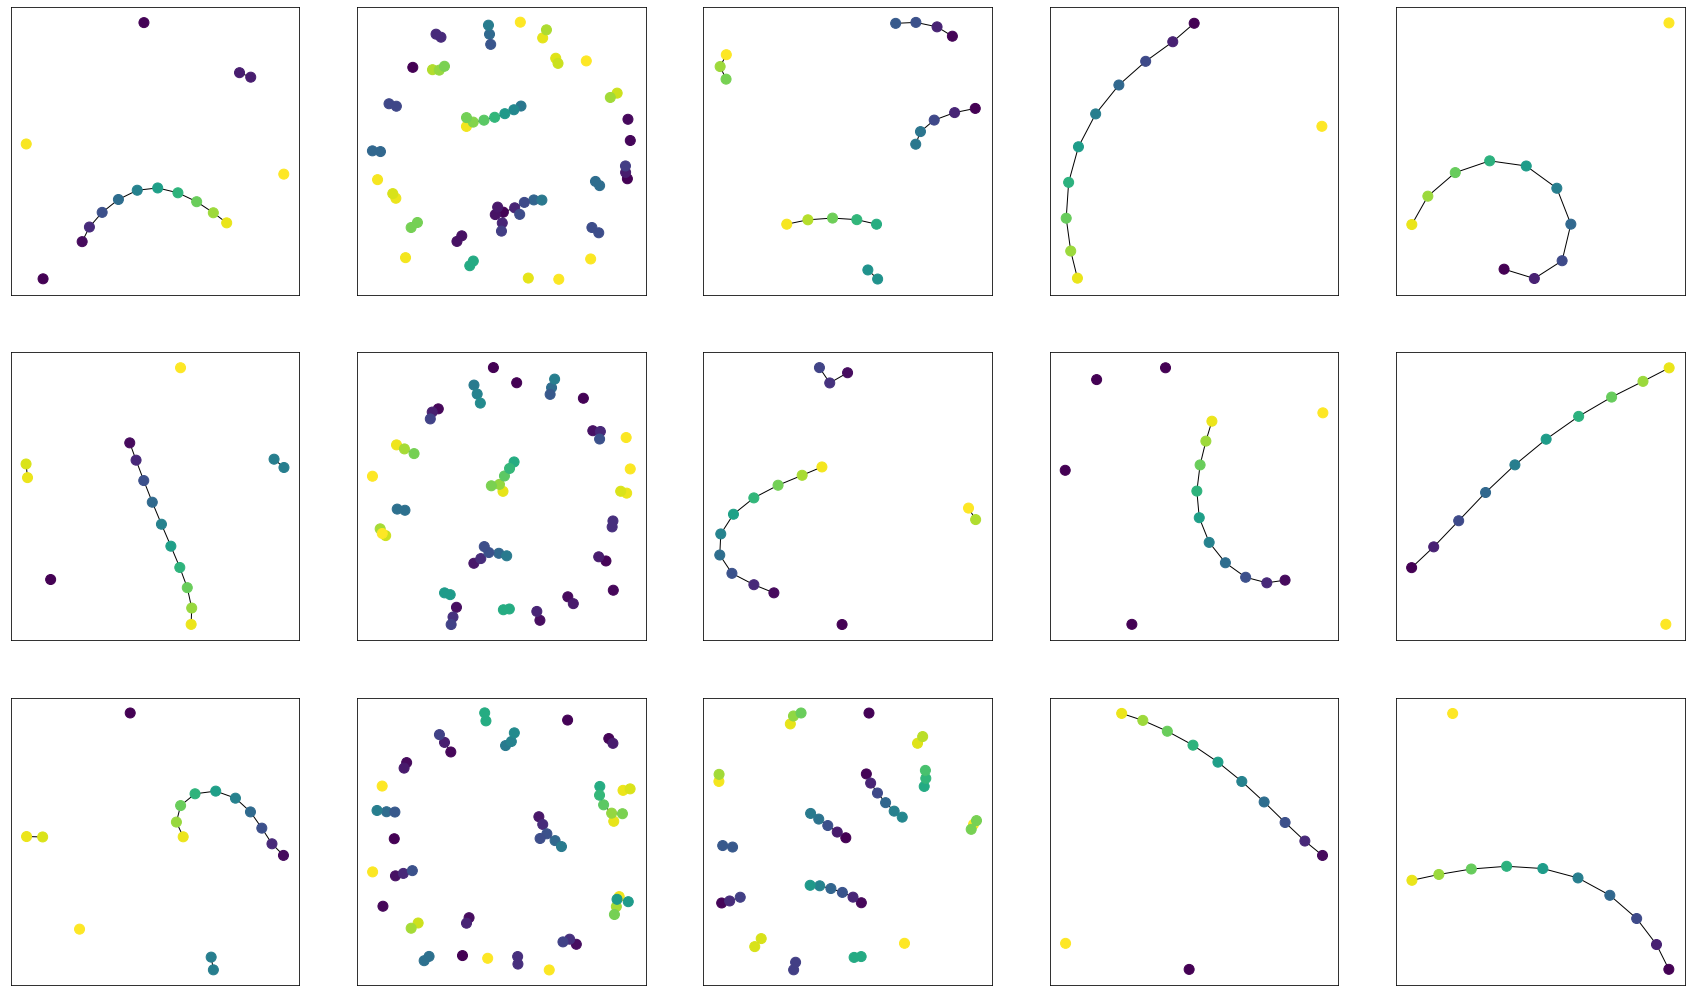

In [243]:
axes = plt.subplots(3, 5, figsize=(30,18))[1].reshape(-1)
all_mappers_flatten = []
vals = []
for (M, ax) in zip(all_mappers, axes):
    G = mapper2networkx(M)
    nx.draw(G, pos=nx.spring_layout(G), 
            node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()], ax=ax,node_size=100)
    vals += [M.node_info_[node]["colors"][0] for node in G.nodes()]
    ax.axis('on')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.show()

## Plotting the row wise sum of pairwise distance matrices to reveal the comparisons

In [244]:

all_dists = np.zeros((len(all_mappers),len(all_mappers)))
for i in range(len(all_mappers)):
    for j in range(i+1,len(all_mappers)):
        all_dists[i,j] = bottleneck_distance(all_mappers[i],all_mappers[j])
        all_dists[j,i] = all_dists[i,j]

Text(0.5, 1.0, 'Topological Consensus Among Different Explanation Methods')

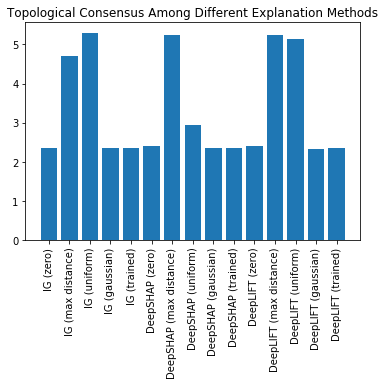

In [245]:
baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']
names = [ '{} ({})'.format(m,b)  for m in methods for b in baselines]
plt.bar(names,np.sum(all_dists,0))
plt.xticks(rotation='vertical')
plt.title('Topological Consensus Among Different Explanation Methods')

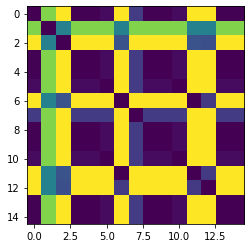

In [193]:
plt.imshow(all_dists)

## Plotting the variances for explanation values from different methods and baselines

In [240]:
p  =predictions.flatten()
variances = []
for m in methods:
    for b in range(len(baselines)):
        variances.append(np.var(explanations[m][b]))

Text(0.5, 1.0, 'Variance of Explanation Values')

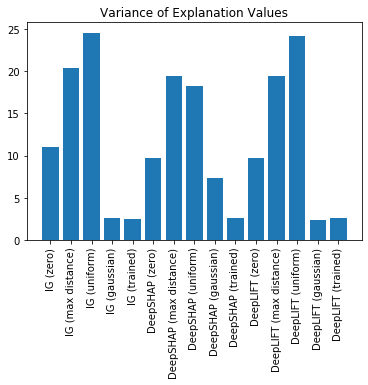

In [241]:
plt.bar(names,variances)
plt.xticks(rotation='vertical')
plt.title('Variance of Explanation Values')